Dependencies installation:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Metrics used across models
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc



#Dependencies used in Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer



#Dependencies used in KNN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

#Random Forest
from sklearn.ensemble import RandomForestClassifier


Now we are going to read our dataset. Notice that the dataset being loaded is the test.csv & train.csv and not JobApplicants.csv - the reason for that is because we have been working on different computers.
The split dataset guarantees that the testrainsplit is consistent as it is not run on both computers.

For more information on how the training set was created please visit traintestspilit.ipynb

In [2]:
# Load the training data
df_train = pd.read_csv('Train.csv')
# Load the test data
df_test = pd.read_csv('Test.csv')

#Check headers
df_train.head()
df_test.head()

,w,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,Country,PreviousSalary,HaveWorkedWith,ComputerSkills,Employed
0,31363,<35,No,Undergraduate,1,Man,No,Dev,9,1,India,7372.0,Bash/Shell;C++;Go;HTML/CSS;JavaScript;Matlab;N...,26,1
1,50414,>35,No,Undergraduate,1,Man,No,Dev,20,14,Canada,77303.0,C#;HTML/CSS;Java;JavaScript;SQL;TypeScript;Doc...,18,1
2,55640,>35,No,NoHigherEd,0,Man,No,Dev,35,31,Germany,89580.0,C;C++;JavaScript;LISP;Managed Hosting,5,0
3,52376,>35,No,Undergraduate,1,Man,No,Dev,30,32,Chile,200000.0,Assembly;Bash/Shell;C;COBOL;Groovy;HTML/CSS;Ja...,27,1
4,12724,>35,No,Master,1,Man,No,Dev,30,21,Russian Federation,28308.0,C#;Java;SQL;ASP.NET;Spring;Microsoft SQL Serve...,7,1


In [3]:
df_train.drop(['w'], axis=1, inplace=True)
df_test.drop(['w'], axis=1, inplace=True)

In [4]:
df_train['Age_over_35'] = df_train['Age'].apply(lambda x: 1 if x == '>35' else 0)
df_test['Age_over_35'] = df_test['Age'].apply(lambda x: 1 if x == '>35' else 0)

## Arranging the data

In [5]:
categorical_cols = ['Age', 'EdLevel', 'Gender', 'MainBranch']
numerical_cols = ['YearsCode', 'YearsCodePro', 'PreviousSalary', 'ComputerSkills']

X_train = df_train[categorical_cols + numerical_cols]  
y_train = df_train['Employed']
X_test = df_test[categorical_cols + numerical_cols]  
y_test = df_test['Employed']

Testing to see if train and test has the same ammount of data and different rows

In [6]:
X_train

,Age,EdLevel,Gender,MainBranch,YearsCode,YearsCodePro,PreviousSalary,ComputerSkills
0,>35,Other,Man,NotDev,35,15,77556.0,16
1,>35,PhD,Man,Dev,35,30,124092.0,7
2,<35,Master,NonBinary,Dev,18,2,78672.0,12
3,<35,Undergraduate,Man,Dev,10,1,44790.0,7
4,>35,Master,Man,Dev,21,17,155112.0,16
...,...,...,...,...,...,...,...,...
51418,>35,Undergraduate,Man,Dev,30,21,117229.0,7
51419,>35,Undergraduate,Man,Dev,30,22,58368.0,17
51420,<35,Undergraduate,Man,Dev,8,1,51663.0,15
51421,<35,Undergraduate,Man,Dev,9,8,62697.0,11


In [7]:
X_test

,Age,EdLevel,Gender,MainBranch,YearsCode,YearsCodePro,PreviousSalary,ComputerSkills
0,<35,Undergraduate,Man,Dev,9,1,7372.0,26
1,>35,Undergraduate,Man,Dev,20,14,77303.0,18
2,>35,NoHigherEd,Man,Dev,35,31,89580.0,5
3,>35,Undergraduate,Man,Dev,30,32,200000.0,27
4,>35,Master,Man,Dev,30,21,28308.0,7
...,...,...,...,...,...,...,...,...
22034,<35,Master,Man,Dev,10,1,51887.0,21
22035,<35,Master,Man,Dev,16,9,90647.0,17
22036,<35,Undergraduate,Man,Dev,12,8,54049.0,22
22037,<35,Undergraduate,Man,Dev,5,2,21408.0,21


In [8]:
y_train

0        0
1        1
2        1
3        0
4        1
        ..
51418    0
51419    0
51420    1
51421    1
51422    1
Name: Employed, Length: 51423, dtype: int64

In [9]:
y_test

0        1
1        1
2        0
3        1
4        1
        ..
22034    1
22035    1
22036    1
22037    1
22038    1
Name: Employed, Length: 22039, dtype: int64

# Logistic Regression

This pipeline handles the categorical data. It first replaces missing values with the most frequent value in each column and then applies one-hot encoding to convert categorical variables into a set of binary variables.

In [10]:
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Replace missing values with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Convert categorical variable into dummy/indicator variables
])

This pipeline processes the numerical data. It replaces missing values with the median and then scales the data using standardization (z-score normalization).

In [11]:
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Replace missing values with the median
    ('scaler', StandardScaler())
])

Allow different columns or column subsets of the input to be transformed separately and the features generated by each transformer will be concatenated to form a single feature space.

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ])

We integrate the preprocessing steps with a logistic regression classifier in a single pipeline.

In [13]:
# Create the logistic regression pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

Train the logistic regression model using the training data.

In [14]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['YearsCode', 'YearsCodePro',
                                                   'PreviousSalary',
                                                   'ComputerSkills']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Age', 'EdLevel', 'Gender',
                                                   'MainBranch'])])),
                ('classifier', LogisticRegression())])

In [15]:
print("Training set score: {:.3f}".format(pipeline.score(X_train, y_train)))
print("Test score: {:.5f}".format(pipeline.score(X_test, y_test)))

Training set score: 0.785
Test score: 0.78284


Evaluate the model's performance using various metrics such as accuracy, F1 score, precision, and recall.

In [16]:
y_pred = pipeline.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')  # Adjust based on your target variable
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.7828395117745814
F1 Score: 0.7968073363335314
Precision: 0.7978234994048631
Recall: 0.7957937584803256


In [17]:
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__class_weight': [None, 'balanced'],
    'classifier__solver': ['liblinear', 'lbfgs']  
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)



Best parameters: {'classifier__C': 10, 'classifier__class_weight': None, 'classifier__solver': 'liblinear'}


In [18]:
# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.7829302599936476
F1 Score: 0.7969094922737306
Precision: 0.7978578714722884
Recall: 0.7959633649932157


In [19]:
predictions= best_model.predict(X_test)
# Now, we will calculate the mean prediction for each gender group
mean_prediction_man = predictions[df_test['Gender'] == 'Man'].mean()
mean_prediction_woman = predictions[df_test['Gender'] == 'Woman'].mean()

# Finally, we compute the demographic parity difference between 'Man' and 'Woman'
demographic_parity_difference = mean_prediction_man - mean_prediction_woman

print(f"Demographic parity difference: {demographic_parity_difference}")

Demographic parity difference: 0.13175682935721172


### Feature Importance

After training the logistic regression model, it's insightful to examine the coefficients assigned to each feature to understand their importance.

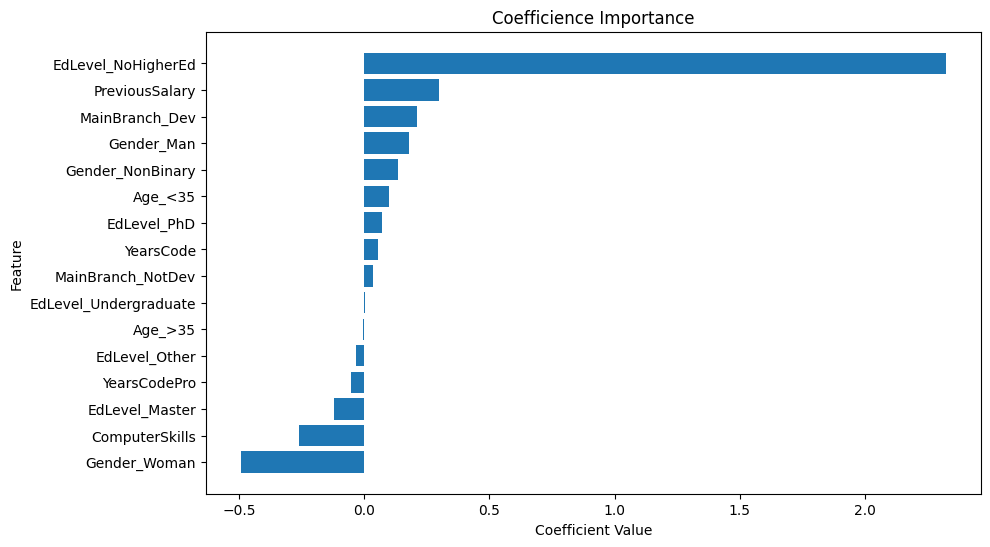

,Feature,Coefficient
3,EdLevel_NoHigherEd,2.321375
14,PreviousSalary,0.298723
10,MainBranch_Dev,0.210726
7,Gender_Man,0.180489
8,Gender_NonBinary,0.136550
0,Age_<35,0.099672
5,EdLevel_PhD,0.072156
12,YearsCode,0.056590
11,MainBranch_NotDev,0.036769
6,EdLevel_Undergraduate,0.003825


In [20]:
# 1. Extract the feature names from the one-hot encoder within the pipeline
ohe = (best_model.named_steps['preprocessor']
       .named_transformers_['cat']
       .named_steps['onehot'])
feature_names_cat = ohe.get_feature_names_out(input_features=categorical_cols)

# Concatenate with numerical feature names to get the full list
feature_names = np.concatenate([feature_names_cat, numerical_cols], axis=0)
coefficients = best_model.named_steps['classifier'].coef_.flatten()
#import matplotlib.pyplot as plt

# Sort the features by their coefficient values
sorted_indices = np.argsort(coefficients)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_indices)), coefficients[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), feature_names[sorted_indices])
plt.xlabel("Coefficient Value")
plt.title('Coefficience Importance')
plt.ylabel("Feature")
plt.show()
# Create a DataFrame with feature names and coefficients
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the DataFrame by the coefficient values
sorted_feature_df = feature_df.sort_values(by='Coefficient', ascending=False)

# Display the DataFrame
sorted_feature_df

As it is unexpected that ComputerSkills have a negative coefficient value, we did some further analysis on correlation between the features

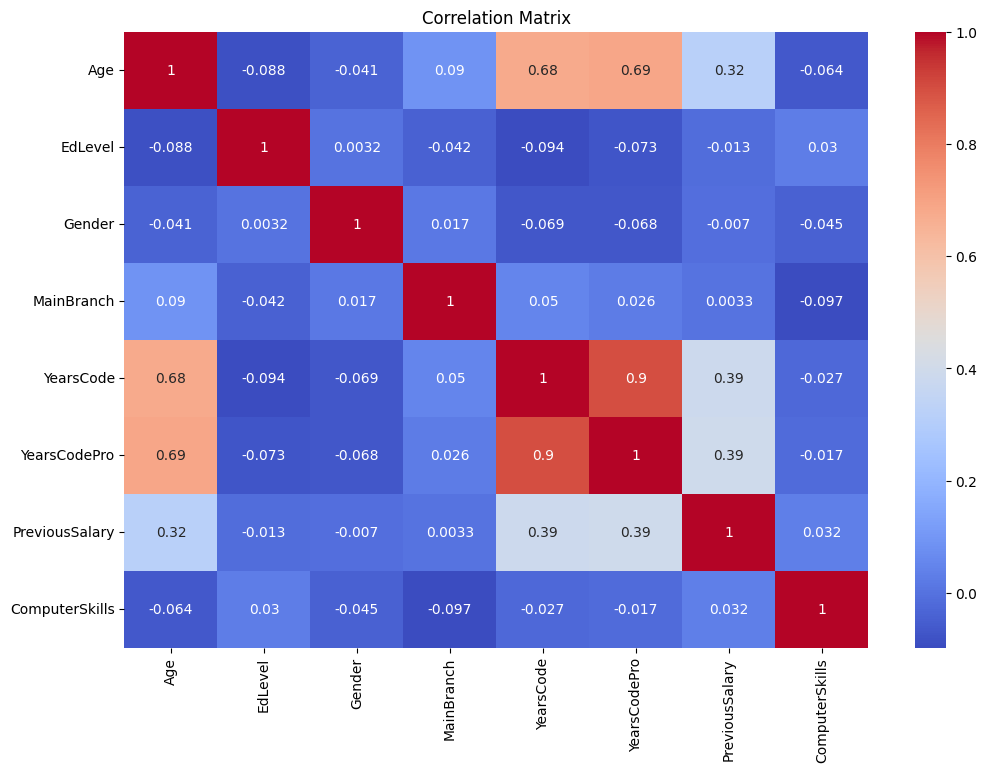

In [53]:
# Combine your categorical and numerical columns for correlation analysis
all_columns = categorical_cols + numerical_cols

# For categorical data, we need to convert them into numerical format. One way is to use get_dummies()
df_for_correlation = pd.get_dummies(df_train[all_columns])

# Calculate the correlation matrix
correlation_matrix = df_for_correlation.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

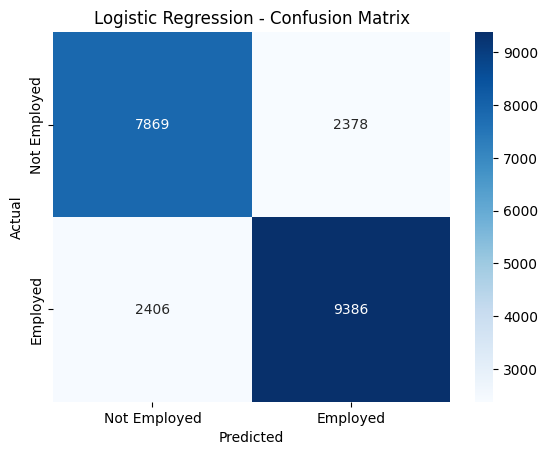

In [22]:
# Plot the confusion matrix
cm_lr = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Employed', 'Employed'], yticklabels=['Not Employed', 'Employed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression - Confusion Matrix')
plt.show()

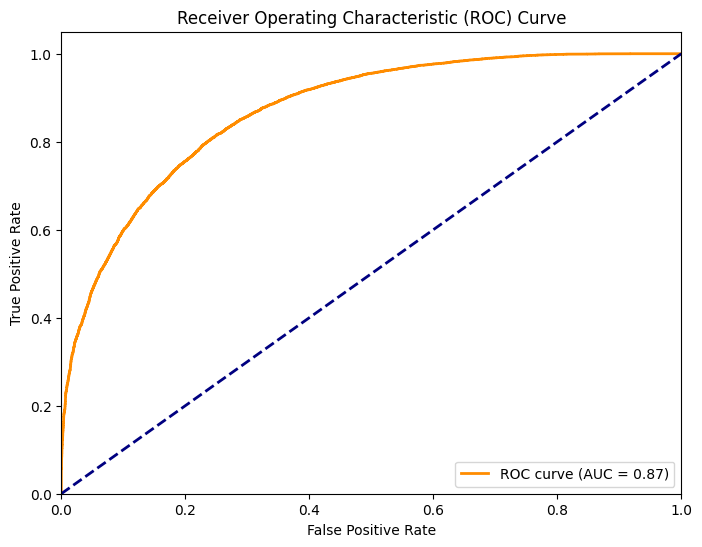

In [23]:
y_prob = best_model.predict_proba(X_test)[:,1]

# Step 2: Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Step 3: Compute the AUC
roc_auc = auc(fpr, tpr)

# Step 4: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

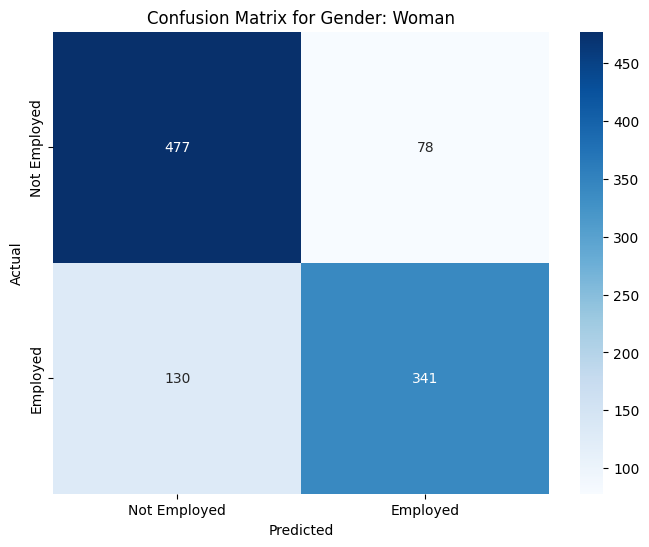

Accuracy: 0.797270955165692
F1 Score: 0.7662921348314606
Precision: 0.8138424821002387
Recall: 0.7239915074309978


In [24]:
GenderChoice = 'Woman'
df_gender_specific = df_test[df_test['Gender'] == GenderChoice]
categorical_cols = ['Age', 'EdLevel','Gender', 'MainBranch']
numerical_cols = ['YearsCode', 'YearsCodePro', 'PreviousSalary', 'ComputerSkills']

X_test_gender_specific = df_gender_specific[categorical_cols + numerical_cols] 
y_test_gender_specific = df_gender_specific['Employed']


y_pred_gender_specific = best_model.predict(X_test_gender_specific)

# Make predictions on the gender-specific test set
y_pred_gender_specific = best_model.predict(X_test_gender_specific)

# Compute the confusion matrix
cm_gender_specific = confusion_matrix(y_test_gender_specific, y_pred_gender_specific)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gender_specific, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Employed', 'Employed'],
            yticklabels=['Not Employed', 'Employed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Gender: ' + GenderChoice)
plt.show()

# Calculate metrics
accuracy = accuracy_score(y_test_gender_specific, y_pred_gender_specific)
f1 = f1_score(y_test_gender_specific, y_pred_gender_specific, average='binary')
precision = precision_score(y_test_gender_specific, y_pred_gender_specific, average='binary')
recall = recall_score(y_test_gender_specific, y_pred_gender_specific, average='binary')

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

#### Visualizing all columns

This part has been created to cover the need to analyze a specific column if relevant

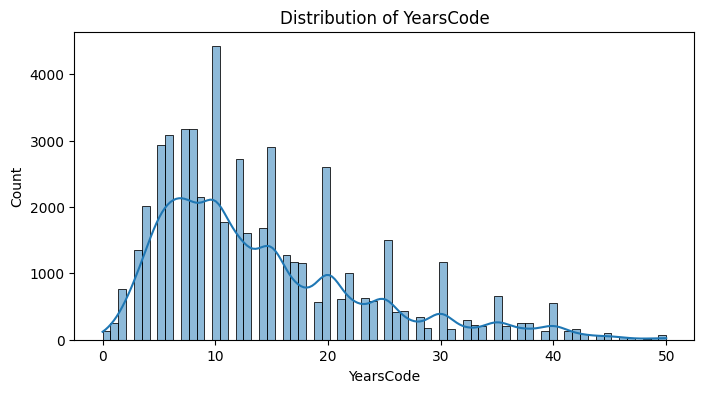

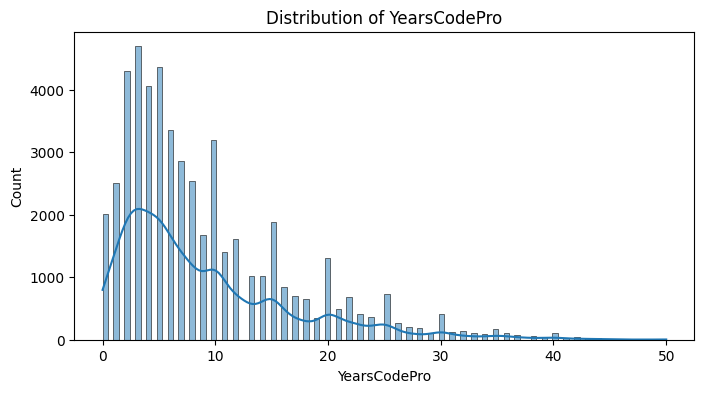

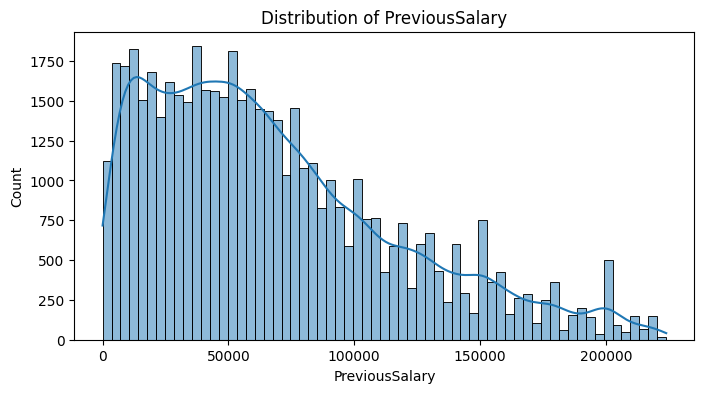

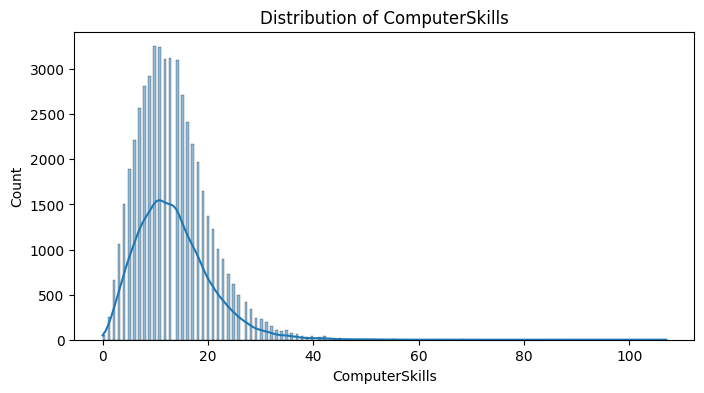

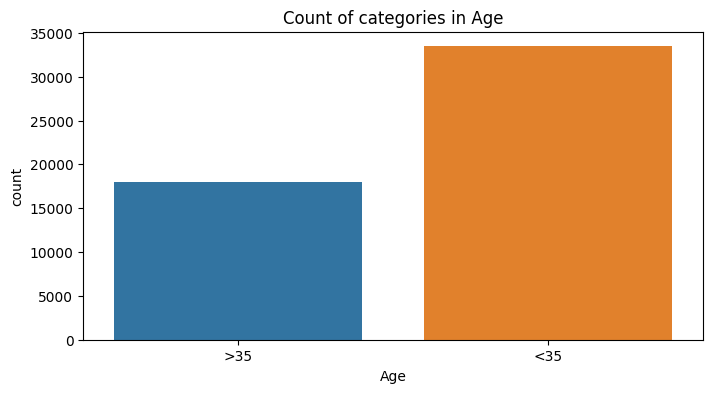

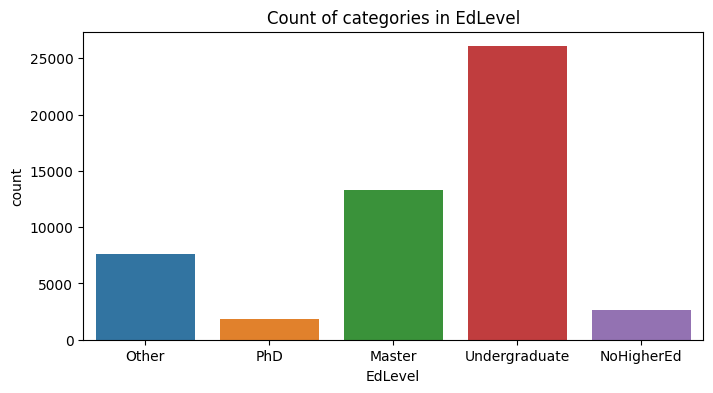

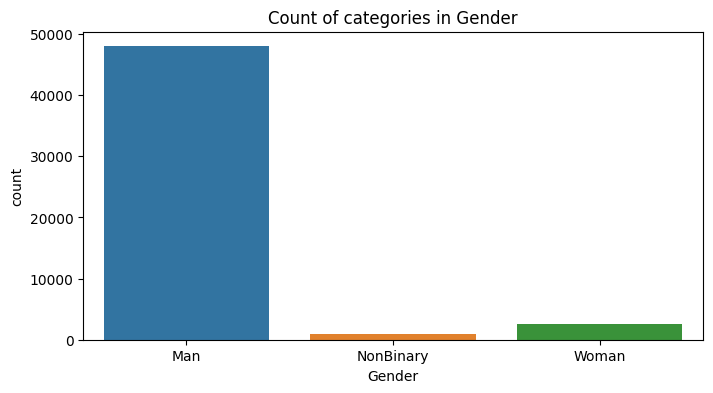

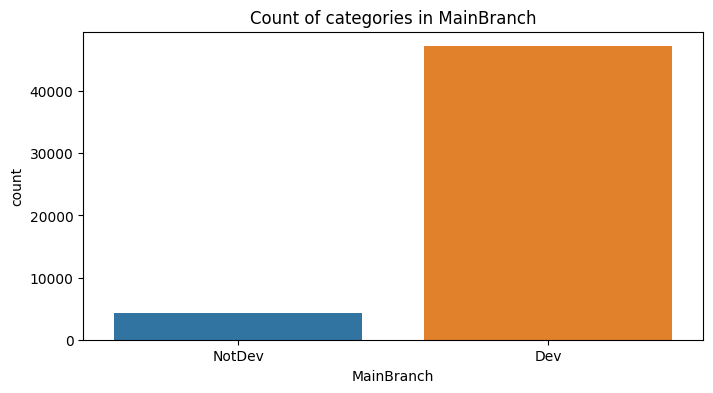

In [25]:
# Visualizing numerical columns
for column in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df_train, x=column, kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

# Visualizing categorical columns
for column in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df_train, x=column)
    plt.title(f'Count of categories in {column}')
    plt.show()

Visualization over the relationship of each column and "Employed"

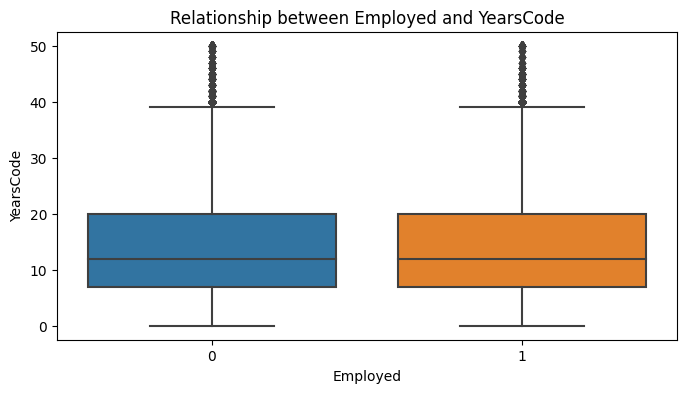

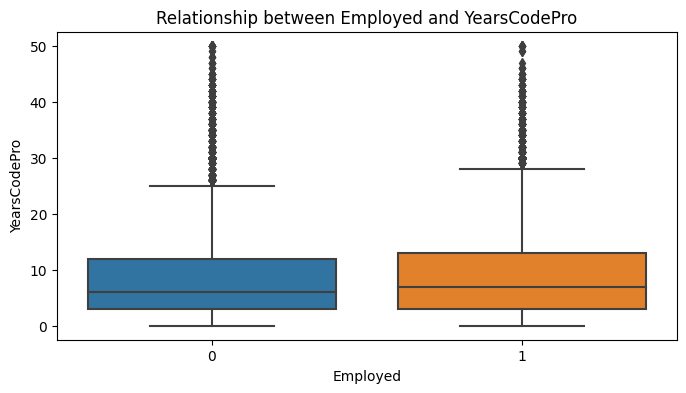

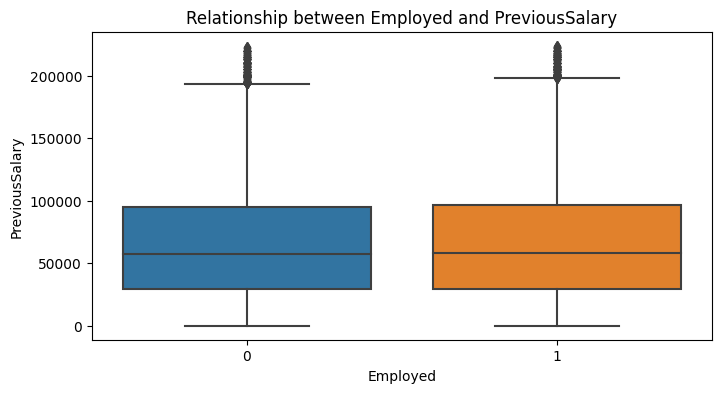

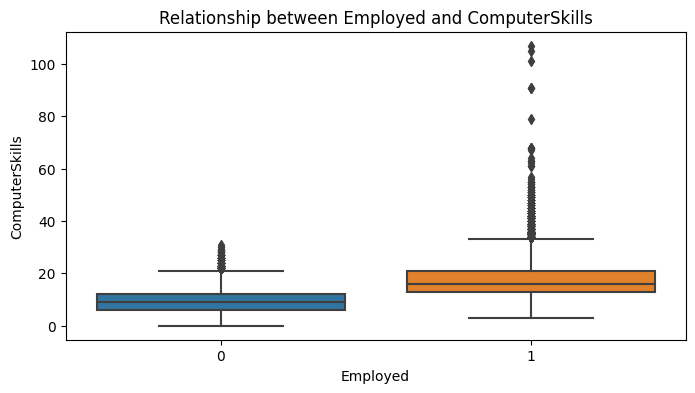

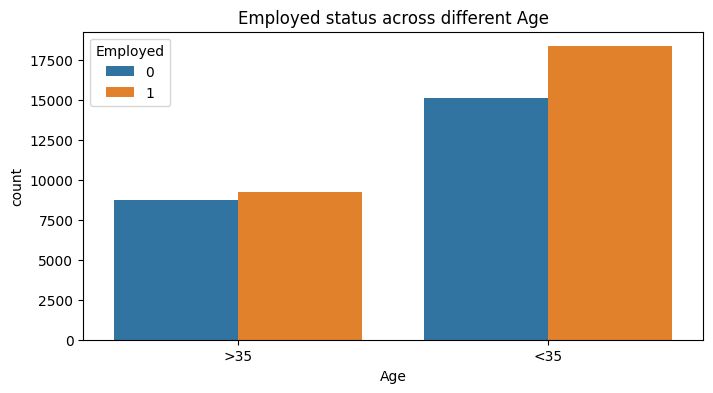

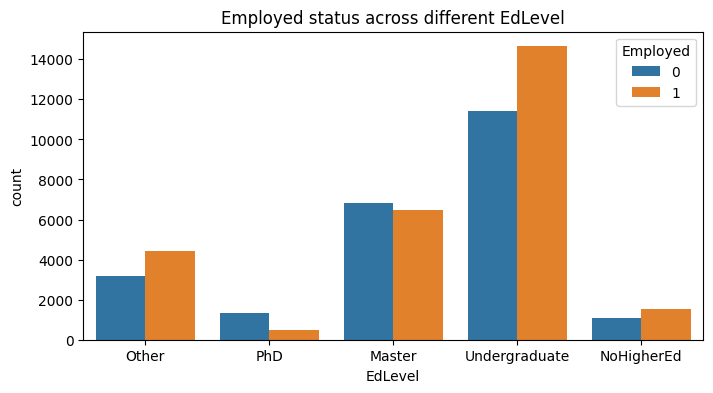

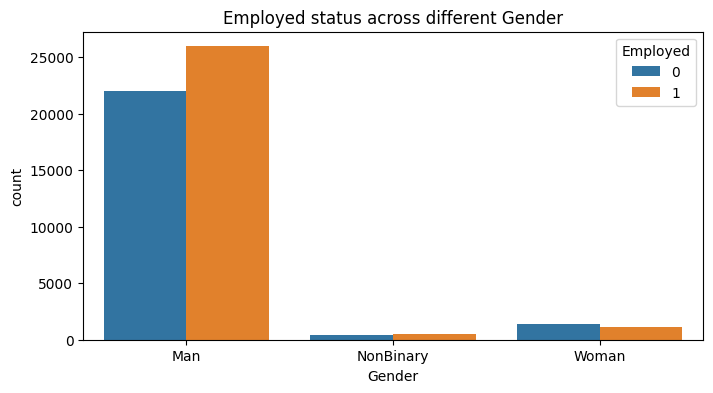

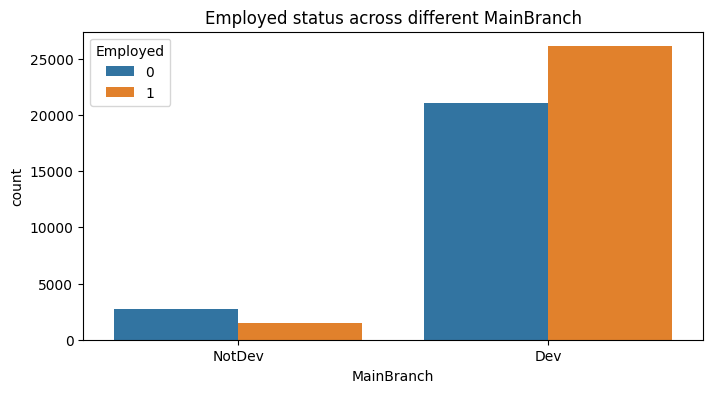

In [26]:
# For numerical features
for column in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='Employed', y=column, data=df_train)
    plt.title(f'Relationship between Employed and {column}')
    plt.show()

# For categorical features
for column in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=column, hue='Employed', data=df_train)
    plt.title(f'Employed status across different {column}')
    plt.show()

# KNN - Model

Categorical variables are encoded to transform them into numerical format, as KNN requires numerical input.

In [27]:
# Encode categorical variables
label_encoders = {}
for column in ['Age', 'EdLevel', 'Gender', 'MainBranch']:
    label_encoders[column] = LabelEncoder()
    df_train[column] = label_encoders[column].fit_transform(df_train[column])
    df_test[column] = label_encoders[column].fit_transform(df_test[column])

We select both categorical and numerical columns as features and a target variable for training and testing the model.

In [28]:
categorical_cols = ['Age', 'EdLevel', 'Gender', 'MainBranch']
numerical_cols = ['YearsCode', 'YearsCodePro', 'PreviousSalary', 'ComputerSkills']

X_train = df_train[categorical_cols + numerical_cols]  
y_train = df_train['Employed']
X_test = df_test[categorical_cols + numerical_cols]  
y_test = df_test['Employed']

KNN is sensitive to the scale of the data, so we apply standard scaling to our features.

In [29]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

A basic KNN classifier is created and fitted with the training data.

In [30]:
knn_basic = KNeighborsClassifier()
knn_basic.fit(X_train_scaled, y_train)

# Making predictions
y_pred_basic = knn_basic.predict(X_test_scaled)

# Evaluating the basic model
print("Basic KNN Model Evaluation")
print(confusion_matrix(y_test, y_pred_basic))

"""print("Training set score: {:.3f}".format(pipeline.score(X_train, y_train)))
print("Test score: {:.5f}".format(pipeline.score(X_test, y_test)))"""
accuracy = accuracy_score(y_test, y_pred_basic)
f1 = f1_score(y_test, y_pred_basic, average='binary')  # Adjust based on your target variable
precision = precision_score(y_test, y_pred_basic, average='binary')
recall = recall_score(y_test, y_pred_basic, average='binary')

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Basic KNN Model Evaluation
[[7351 2896]
 [2567 9225]]
Accuracy: 0.7521212396206725
F1 Score: 0.7715468573579225
Precision: 0.7610758188268295
Recall: 0.7823100407055631


### Tuned Model
We optimize the KNN model by tuning its hyperparameters like the number of neighbors, weights, and distance metric.

In [31]:
# Creating KNN Classifier model
knn = KNeighborsClassifier()

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(knn, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Best Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}


In [32]:
# Training the model with the best parameters
knn_best = grid_search.best_estimator_
knn_best.fit(X_train_scaled, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=11)

In [33]:
y_pred = knn_best.predict(X_test_scaled)

In [34]:
# Evaluating the model
print(confusion_matrix(y_test, y_pred))

"""print("Training set score: {:.3f}".format(pipeline.score(X_train, y_train)))
print("Test score: {:.5f}".format(pipeline.score(X_test, y_test)))"""
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary') 
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

[[7431 2816]
 [2347 9445]]
Accuracy: 0.7657334724806025
F1 Score: 0.7853490209121523
Precision: 0.7703286844466194
Recall: 0.8009667571234735


Demographic parity difference

In [35]:
probabilities = knn_best.predict_proba(X_test_scaled)


group1_mask = (X_test['Gender'] == 0)  # Man
group2_mask = (X_test['Gender'] == 1)  # Woman

# Calculate the mean probability of the positive class for each group
mean_probability_group1 = probabilities[group1_mask, 1].mean()
mean_probability_group2 = probabilities[group2_mask, 1].mean()

# Demographic parity difference
demographic_parity_difference = mean_probability_group1 - mean_probability_group2

print(f"Demographic parity difference for KNN: {demographic_parity_difference}")

Demographic parity difference for KNN: 0.0018836111559178415


Confusion Matrix & ROC Curve

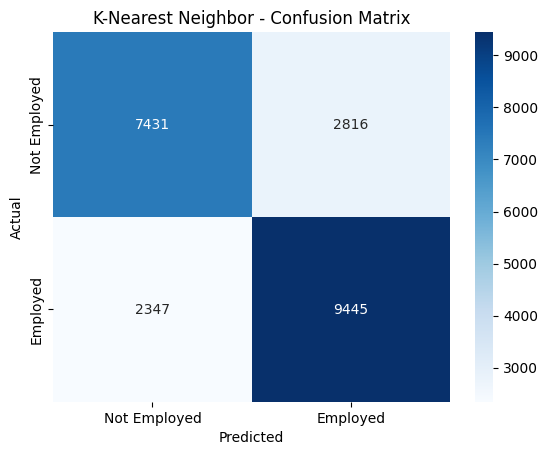

In [36]:
# Plot the confusion matrix
cm_knn = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Employed', 'Employed'], yticklabels=['Not Employed', 'Employed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('K-Nearest Neighbor - Confusion Matrix')
plt.show()

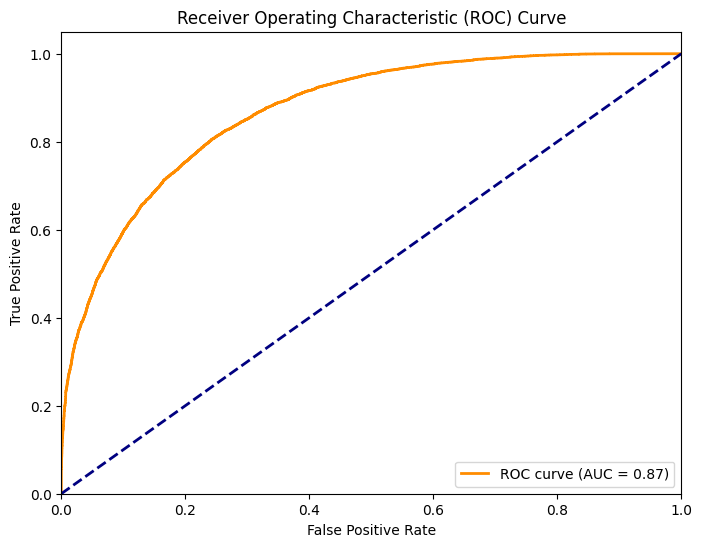

In [37]:
y_prob = best_model.predict_proba(X_test)[:,1]

# Step 2: Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Step 3: Compute the AUC
roc_auc = auc(fpr, tpr)

# Step 4: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Random forest

In [38]:
# Step 1: Load your data
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')

In [39]:
# Step 1,5. We manually convert the age column to binary, as this is not caught by the one-hot encoder
train_df['Age_over_35'] = train_df['Age'].apply(lambda x: 1 if x == '>35' else 0)
test_df['Age_over_35'] = test_df['Age'].apply(lambda x: 1 if x == '>35' else 0)

In [40]:
# Step 3: Create a ColumnTransformer to transform the categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

In [41]:
# Step 4: Create a pipeline that includes the preprocessor and the Random Forest model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42,max_features='sqrt'))
])

In [42]:
# Step 5: Separate features and target variable
X_train = train_df.drop('Employed', axis=1)  
X_train = train_df[categorical_cols + numerical_cols]
y_train = train_df['Employed']
X_test = test_df[categorical_cols + numerical_cols]
y_test = test_df['Employed']

In [43]:
# Step 6: Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# Step 7: Make predictions on the test data
y_pred = pipeline.predict(X_test)

In [44]:
# Step 8: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')  # Adjust based on your target variable
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.7582921185171742
F1 Score: 0.7779584010670668
Precision: 0.764980736125912
Recall: 0.7913839891451832


### Tuned Model

In [45]:
# Define the hyperparameters and their possible values
param_grid = {
    'classifier__n_estimators': [85, 100, 115],
    'classifier__max_depth': [7, 10, 13],
    'classifier__min_samples_split': [10, 12, 15],
    'classifier__min_samples_leaf': [4, 6, 8]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, max_features='sqrt')

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

#Print the best parameters and model
print(f"Best Parameters: {best_params}")
print(f"Best Model: {best_model}")

'#Print the best parameters and model\nprint(f"Best Parameters: {best_params}")\nprint(f"Best Model: {best_model}")'

Exploring if min_samples_split range was set too low

In [46]:
# Define the hyperparameters and their possible values
param_grid = {
    'classifier__min_samples_split': [15, 30, 50]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, max_features='sqrt')

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")
print(f"Best Model: {best_model}")

Best Parameters: {'classifier__min_samples_split': 50}
Best Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['YearsCode', 'YearsCodePro',
                                                   'PreviousSalary',
                                                   'ComputerSkills']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Age', 'EdLevel', 'Gender',
                                                   'MainBranch'])])),
                ('classifier',
                 RandomForestClassifier(min_samples_split=50,
                                        random_state=42))])


In [47]:

# Step 4: Create a pipeline that includes the preprocessor and the Random Forest model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(max_depth=13, min_samples_leaf=6, min_samples_split=15, n_estimators=115, random_state=42, max_features='sqrt'))
])

# Step 6: Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# Step 7: Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Step 8: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary') 
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.7846091020463724
F1 Score: 0.8040615841829364
Precision: 0.7832730197024528
Recall: 0.8259837177747625


In [48]:
probabilities = pipeline.predict_proba(X_test)


group1_mask = (X_test['Gender'] == "Man")  # Man
group2_mask = (X_test['Gender'] == "Woman")  # Woman

# Calculate the mean probability of the positive class for each group
mean_probability_group1 = probabilities[group1_mask, 1].mean()
mean_probability_group2 = probabilities[group2_mask, 1].mean()

# Demographic parity difference
demographic_parity_difference = mean_probability_group1 - mean_probability_group2

print(f"Demographic parity difference for Random Forest (Man - Woman): {demographic_parity_difference}")

Demographic parity difference for Random Forest (Man - Woman): 0.09500122266602123


### Feature importance

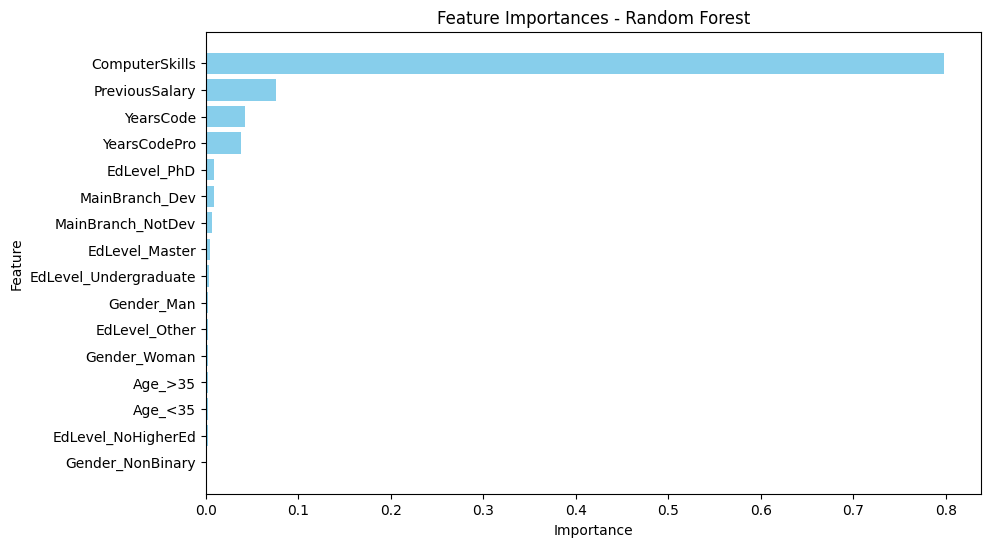

,feature,importance
3,ComputerSkills,0.797993
2,PreviousSalary,0.075567
0,YearsCode,0.042256
1,YearsCodePro,0.037552
9,EdLevel_PhD,0.008948
14,MainBranch_Dev,0.008444
15,MainBranch_NotDev,0.007192
6,EdLevel_Master,0.004182
10,EdLevel_Undergraduate,0.003052
11,Gender_Man,0.002540


In [49]:
# Get feature importances from the classifier
feature_importances = best_model.named_steps['classifier'].feature_importances_

# Get feature names for categorical features from the preprocessor step of the pipeline

# We use get_feature_names_out() to get the feature names and then convert to a list
categorical_feature_names = best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist()

# The numerical feature names are used directly
numerical_feature_names = numerical_cols  # This is already a list

# Combine numerical and categorical feature names
feature_names = numerical_feature_names + categorical_feature_names

# Create a DataFrame to display feature importances
feature_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances}).sort_values('importance', ascending=False)
feature_df.head(16)

# Plotting
plt.figure(figsize=(10, 6))
# Select top 16 features for plotting
top_features = feature_df.head(16)
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances - Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()
feature_df

### Visualization

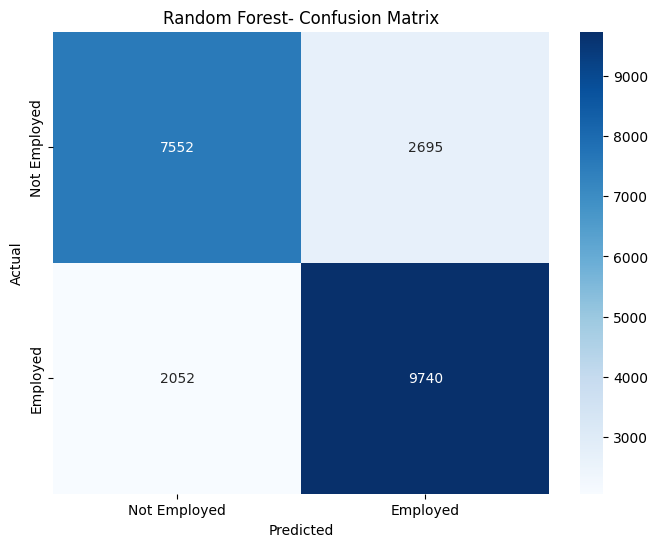

In [50]:
# Generate the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred)  # Assuming y_test are your true labels and y_pred are your predictions

# Create labels for the classes
class_labels = ['Not Employed', 'Employed']  # Replace with your actual class names/labels

# Create a heatmap
plt.figure(figsize=(8, 6))  # Can adjust the size as needed
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Add labels and a title
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Random Forest- Confusion Matrix')

# Show the plot
plt.show()


In [51]:
# Predict the outcomes using the best RandomForest model
y_pred = pipeline.predict(X_test)

# Generate and display the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.74      0.76     10247
           1       0.78      0.83      0.80     11792

    accuracy                           0.78     22039
   macro avg       0.78      0.78      0.78     22039
weighted avg       0.78      0.78      0.78     22039



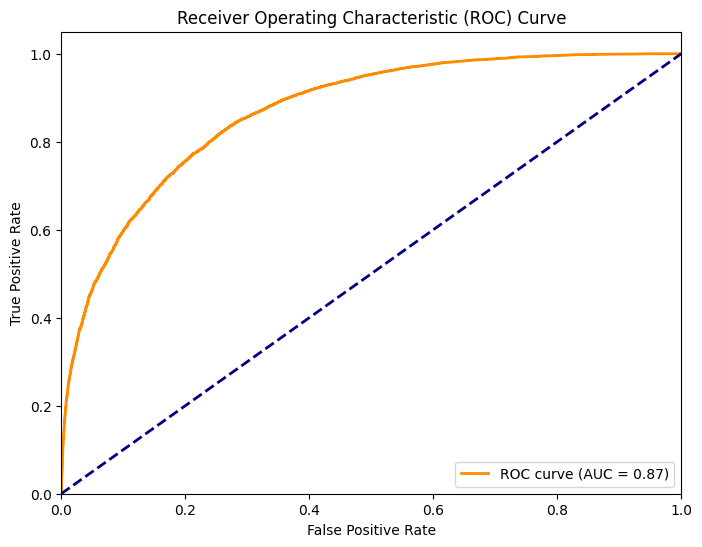

In [52]:

# Step 1: Compute the predicted probabilities for the positive class
y_prob = pipeline.predict_proba(X_test)[:,1]

# Step 2: Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Step 3: Compute the AUC
roc_auc = auc(fpr, tpr)

# Step 4: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()